Loading data from ITSM_data.csv...


C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_3984\1095501251.py:19: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Initial data loaded. Performing cleaning and feature derivation...
Data cleaning and target derivation complete.

--- Sample ITSM Data (after initial cleaning) ---
     CI_Name          CI_Cat              CI_Subcat        WBS Incident_ID  \
0  SUB000508  subapplication  Web Based Application  WBS000162   IM0000004   
1  WBA000124     application  Web Based Application  WBS000088   IM0000005   
2  DTA000024     application    Desktop Application  WBS000092   IM0000006   
3  WBA000124     application  Web Based Application  WBS000088   IM0000011   
4  WBA000124     application  Web Based Application  WBS000088   IM0000012   

   Status  Impact  Urgency  Priority  number_cnt  ...        Close_Time  \
0  Closed     4.0      4.0       4.0    0.601292  ...   4/11/2023 13:51   
1  Closed     3.0      3.0       3.0    0.415050  ...   2/12/2023 12:36   
2  Closed     4.0      3.0       4.0    0.517551  ...  13-01-2024 15:13   
3  Closed     4.0      4.0       4.0    0.642927  ...  14-11-2023 0

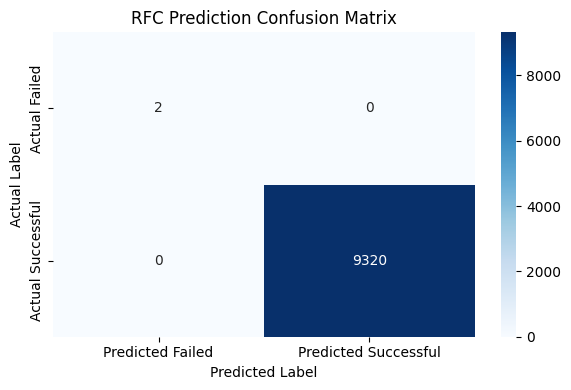

RFC Failure Prediction Model training complete.
Training Asset Misconfiguration Anomaly Detection Model...
X_asset_for_model format before fitting: csr
Estimated contamination rate for IsolationForest: 0.0620


ValueError: X should be in csr_matrix format, got <class 'scipy.sparse._csc.csc_matrix'>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix, issparse # Import issparse for checking

def load_itsm_data(file_path="ITSM_data.csv"):
    """
    Loads ITSM data from a CSV file and performs initial cleaning.
    This includes parsing 'Handle_Time_hrs' and deriving target variables.
    """
    print(f"Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Please ensure the file is in the correct directory.")
        return pd.DataFrame()  # Return empty DataFrame on error

    print("Initial data loaded. Performing cleaning and feature derivation...")

    def parse_handle_time(time_str):
        if pd.isna(time_str):
            return np.nan
        try:
            # Improved handling of comma as decimal separator
            time_str = str(time_str).replace(',', '.')  # Ensure it's a string before replacing
            return float(time_str)
        except ValueError:
            return np.nan

    if 'Handle_Time_hrs' in df.columns:
        df['Handle_Time_hrs'] = df['Handle_Time_hrs'].apply(parse_handle_time)

    numerical_cols_to_fill = [
        'Impact', 'Urgency', 'Priority', 'number_cnt', 'No_of_Reassignments',
        'No_of_Related_Interactions', 'No_of_Related_Incidents', 'No_of_Related_Changes',
        'Handle_Time_hrs'
    ]
    for col in numerical_cols_to_fill:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col].fillna(df[col].median(), inplace=True) # Fill NaNs after conversion

    if 'Status' in df.columns:
        df['rfc_successful'] = df['Status'].apply(lambda x: 1 if x == 'Closed' else 0)
    else:
        df['rfc_successful'] = 0  # Default if Status missing

    # Derive misconfiguration proxy flag
    df['is_misconfigured_proxy'] = 0
    for col in ['No_of_Related_Incidents', 'No_of_Related_Changes', 'No_of_Reassignments']:
        if col not in df.columns:
            df[col] = 0  # Fill missing columns with 0

    # Use .loc for assignment to avoid SettingWithCopyWarning
    df.loc[
        (df['No_of_Related_Incidents'] > df['No_of_Related_Incidents'].quantile(0.95)) |
        (df['No_of_Related_Changes'] > df['No_of_Related_Changes'].quantile(0.95)) |
        (df['No_of_Reassignments'] > df['No_of_Reassignments'].quantile(0.95)),
        'is_misconfigured_proxy'
    ] = 1

    print("Data cleaning and target derivation complete.")
    return df

def preprocess_data(itsm_df):
    """
    Preprocesses the ITSM DataFrame for both RFC prediction and asset anomaly detection.
    Handles categorical encoding and numerical scaling.
    """
    print("Starting data preprocessing...")

    # Define all relevant features for RFC prediction.
    numerical_features_rfc = [
        'Priority', 'number_cnt', 'No_of_Reassignments', 'Handle_Time_hrs',
        'No_of_Related_Interactions', 'No_of_Related_Incidents', 'No_of_Related_Changes',
        'Impact', 'Urgency'
    ]
    categorical_features_rfc = [
        'CI_Cat', 'CI_Subcat', 'Status', 'Category', 'Alert_Status', 'Closure_Code'
    ]

    # Filter features to only include columns that exist in the DataFrame
    numerical_features_rfc = [f for f in numerical_features_rfc if f in itsm_df.columns]
    categorical_features_rfc = [f for f in categorical_features_rfc if f in itsm_df.columns]

    all_rfc_features = numerical_features_rfc + categorical_features_rfc
    df_for_rfc_prep = itsm_df[all_rfc_features].copy()

    preprocessor_rfc = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features_rfc),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_rfc)
        ],
        remainder='drop'
    )

    X_rfc = preprocessor_rfc.fit_transform(df_for_rfc_prep)
    # Ensure X_rfc is CSR format, as ColumnTransformer might output CSC by default
    if issparse(X_rfc) and X_rfc.format != 'csr':
        X_rfc = X_rfc.tocsr()
    elif not issparse(X_rfc): # Convert to sparse if it's not already
        X_rfc = csr_matrix(X_rfc)
    y_rfc = itsm_df['rfc_successful']

    asset_group_cols = ['CI_Name', 'CI_Cat', 'CI_Subcat']
    asset_agg_cols = [
        'No_of_Related_Interactions', 'No_of_Related_Incidents',
        'No_of_Related_Changes', 'No_of_Reassignments', 'Handle_Time_hrs',
        'Impact', 'Urgency', 'Priority', 'number_cnt'
    ]

    asset_group_cols = [col for col in asset_group_cols if col in itsm_df.columns]
    asset_agg_cols = [col for col in asset_agg_cols if col in itsm_df.columns]

    asset_df_for_anomaly = itsm_df.groupby(asset_group_cols)[asset_agg_cols].mean().reset_index()
    asset_df_for_anomaly.fillna(0, inplace=True)

    asset_df_for_anomaly['is_misconfigured_proxy'] = 0
    for col in ['No_of_Related_Incidents', 'No_of_Related_Changes', 'No_of_Reassignments']:
        if col not in asset_df_for_anomaly.columns:
            asset_df_for_anomaly[col] = 0

    asset_df_for_anomaly.loc[
        (asset_df_for_anomaly['No_of_Related_Incidents'] > asset_df_for_anomaly['No_of_Related_Incidents'].quantile(0.95)) |
        (asset_df_for_anomaly['No_of_Related_Changes'] > asset_df_for_anomaly['No_of_Related_Changes'].quantile(0.95)) |
        (asset_df_for_anomaly['No_of_Reassignments'] > asset_df_for_anomaly['No_of_Reassignments'].quantile(0.95)),
        'is_misconfigured_proxy'
    ] = 1

    y_asset_misconfigured = asset_df_for_anomaly['is_misconfigured_proxy']

    numerical_features_asset = asset_agg_cols
    categorical_features_asset = [f for f in ['CI_Cat', 'CI_Subcat'] if f in asset_df_for_anomaly.columns]

    all_asset_features = numerical_features_asset + categorical_features_asset
    df_for_asset_prep = asset_df_for_anomaly[all_asset_features].copy()

    preprocessor_asset = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features_asset),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_asset)
        ],
        remainder='drop'
    )

    X_asset = preprocessor_asset.fit_transform(df_for_asset_prep)

    # CRITICAL FIX: Ensure X_asset is CSR format immediately after transformation
    if issparse(X_asset) and X_asset.format != 'csr':
        X_asset = X_asset.tocsr()
    elif not issparse(X_asset):
        X_asset = csr_matrix(X_asset)

    print("Data preprocessing complete.")
    return (X_rfc, y_rfc, X_asset, y_asset_misconfigured,
            preprocessor_rfc, preprocessor_asset,
            all_rfc_features, all_asset_features)

def train_rfc_prediction_model(X_rfc, y_rfc):
    """
    Trains a RandomForestClassifier model to predict RFC success/failure.
    """
    print("Training RFC Failure Prediction Model...")

    X_train, X_test, y_train, y_test = train_test_split(
        X_rfc, y_rfc, test_size=0.2, random_state=42, stratify=y_rfc
    )

    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\n--- RFC Prediction Model Evaluation ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Failed', 'Successful']))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Failed', 'Predicted Successful'],
                yticklabels=['Actual Failed', 'Actual Successful'])
    plt.title('RFC Prediction Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("RFC Failure Prediction Model training complete.")
    return model

def train_anomaly_detection_model(X_asset, y_asset_misconfigured):
    """
    Trains an IsolationForest model to detect anomalies (misconfigurations) in asset data.
    """
    print("Training Asset Misconfiguration Anomaly Detection Model...")

    # Ensure X_asset_for_model is definitively in CSR format
    # This will convert any sparse matrix (like csc_matrix) to csr_matrix.
    # If X_asset is already csr_matrix, it's a no-op.
    # If X_asset is a dense array, it will convert it to csr_matrix.
    X_asset_for_model = csr_matrix(X_asset)
    
    print(f"X_asset_for_model format before fitting: {X_asset_for_model.format}")

    if y_asset_misconfigured.sum() == 0:
        print("No misconfigured assets found. Setting contamination to a default value (e.g., 0.1).")
        contamination_rate = 0.1
    else:
        contamination_rate = y_asset_misconfigured.value_counts(normalize=True).get(1, 0)
        if contamination_rate == 0:
            contamination_rate = 0.1
        elif contamination_rate > 0.5:
            contamination_rate = 0.5
        print(f"Estimated contamination rate for IsolationForest: {contamination_rate:.4f}")

    model = IsolationForest(random_state=42, contamination=contamination_rate)
    
    model.fit(X_asset_for_model).set_output(transform='pandas')# Use the CSR X_asset for fitting

    anomaly_scores = model.decision_function(X_asset_for_model) # Use the CSR X_asset for scoring
    anomaly_predictions = model.predict(X_asset_for_model) # Use the CSR X_asset for predicting
    predicted_misconfigured = np.where(anomaly_predictions == -1, 1, 0)

    print("\n--- Anomaly Detection Model Evaluation (on training data) ---")
    print("Classification Report (Anomaly Detection):")
    print(classification_report(y_asset_misconfigured, predicted_misconfigured,
                                target_names=['Normal', 'Misconfigured'], zero_division=0))
    print("Confusion Matrix (Anomaly Detection):")
    print(confusion_matrix(y_asset_misconfigured, predicted_misconfigured))

    plt.figure(figsize=(10, 6))
    sns.histplot(anomaly_scores, bins=50, kde=True)
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score (Lower = More Anomalous)')
    plt.ylabel('Frequency')
    plt.show()

    print("Asset Misconfiguration Anomaly Detection Model training complete.")
    return model

def predict_risks(new_itsm_record, rfc_model, anomaly_model,
                  rfc_preprocessor, asset_preprocessor,
                  rfc_features_used, asset_features_used):
    """
    Predicts RFC success/failure and detects asset misconfigurations for a new ITSM record.
    """
    print("\n--- Making Predictions for New Data ---")

    if not isinstance(new_itsm_record, pd.DataFrame):
        new_itsm_record = pd.DataFrame([new_itsm_record])

    rfc_input_df = new_itsm_record.reindex(columns=rfc_features_used, fill_value=np.nan)
    for col in rfc_input_df.columns:
        if rfc_input_df[col].dtype in ['float64', 'int64'] and rfc_input_df[col].isnull().any():
            rfc_input_df[col] = pd.to_numeric(rfc_input_df[col], errors='coerce').fillna(0)

    X_new_rfc = rfc_preprocessor.transform(rfc_input_df)
    # Explicitly convert X_new_rfc to CSR format immediately after transformation
    if issparse(X_new_rfc) and X_new_rfc.format != 'csr':
        X_new_rfc = X_new_rfc.tocsr()
    elif not issparse(X_new_rfc):
        X_new_rfc = csr_matrix(X_new_rfc)

    rfc_prediction = rfc_model.predict(X_new_rfc)
    rfc_probability = rfc_model.predict_proba(X_new_rfc)[:, 1]

    asset_features_for_pred = new_itsm_record.reindex(columns=asset_features_used, fill_value=np.nan)
    for col in asset_features_for_pred.columns:
        if asset_features_for_pred[col].dtype in ['float64', 'int64'] and asset_features_for_pred[col].isnull().any():
            asset_features_for_pred[col] = pd.to_numeric(asset_features_for_pred[col], errors='coerce').fillna(0)

    X_new_asset = asset_preprocessor.transform(asset_features_for_pred)
    # CRITICAL FIX for prediction: Explicitly convert X_new_asset to CSR format immediately after transformation
    X_new_asset = csr_matrix(X_new_asset) # Unconditionally convert to csr_matrix


    anomaly_score = anomaly_model.decision_function(X_new_asset)
    anomaly_label = anomaly_model.predict(X_new_asset)

    rfc_outcome = "Successful" if rfc_prediction[0] == 1 else "Failed"
    asset_anomaly = "Misconfigured (Anomaly Detected)" if anomaly_label[0] == -1 else "Normal Configuration"

    incident_id = new_itsm_record['Incident_ID'].iloc[0] if 'Incident_ID' in new_itsm_record.columns else "Unknown"
    ci_name = new_itsm_record['CI_Name'].iloc[0] if 'CI_Name' in new_itsm_record.columns else "Unknown"

    print(f"\nIncident ID: {incident_id}")
    print(f"CI Name: {ci_name}")
    print(f"Predicted RFC Outcome: {rfc_outcome} (Probability of Success: {rfc_probability[0]:.2f})")
    print(f"Asset Configuration Status: {asset_anomaly} (Anomaly Score: {anomaly_score[0]:.2f})")

    return rfc_outcome, rfc_probability[0], asset_anomaly, anomaly_score[0]

if __name__ == "__main__":
    itsm_data = load_itsm_data(file_path="ITSM_data.csv")

    if itsm_data.empty:
        print("Exiting due to data loading error.")
    else:
        print("\n--- Sample ITSM Data (after initial cleaning) ---")
        print(itsm_data.head())
        print(f"Total records loaded: {len(itsm_data)}")

        X_rfc_processed, y_rfc_target, X_asset_processed, y_asset_misconfigured_target, \
        rfc_preprocessor_fitted, asset_preprocessor_fitted, \
        rfc_features_for_pred, asset_features_for_pred = \
            preprocess_data(itsm_data)

        # Added a print to explicitly check the type of X_asset_processed
        print(f"Type of X_asset_processed after preprocessing: {type(X_asset_processed)}")
        if issparse(X_asset_processed):
            print(f"Format of X_asset_processed: {X_asset_processed.format}")


        rfc_prediction_model = train_rfc_prediction_model(X_rfc_processed, y_rfc_target)

        anomaly_detection_model = train_anomaly_detection_model(X_asset_processed, y_asset_misconfigured_target)

        print("\n--- Demonstrating Predictions for New ITSM Records ---")

        new_itsm_record_1 = {
            'CI_Cat': 'application',
            'CI_Subcat': 'Server Based Application',
            'CI_Name': 'ServerApp01',
            'WBS': 'WBS000073',
            'Priority': 1,
            'number_cnt': 0.5,
            'Category': 'incident',
            'KB_number': 'KM0000000',
            'Alert_Status': 'active',
            'Open_Time': '25-07-2025 10:00',
            'Reopen_Time': np.nan,
            'Resolved_Time': np.nan,
            'Close_Time': np.nan,
            'Closure_Code': np.nan,
            'No_of_Related_Interactions': 5,
            'No_of_Related_Changes': 3,
            'No_of_Related_Incidents': 0,
            'No_of_Reassignments': 0,
            'Handle_Time_hrs': np.nan,
            'Related_Change': np.nan,
            'Status': 'Open',
            'Impact': 3,
            'Urgency': 3,
            'Incident_ID': 'IM0000001'
        }
        predict_risks(new_itsm_record_1,
                      rfc_prediction_model, anomaly_detection_model,
                      rfc_preprocessor_fitted, asset_preprocessor_fitted,
                      rfc_features_for_pred, asset_features_for_pred)

        new_itsm_record_2 = {
            'CI_Cat': 'application',
            'CI_Subcat': 'Web Based Application',
            'CI_Name': 'WebApp01',
            'WBS': 'WBS000088',
            'Incident_ID': 'IM8888888',
            'Status': 'Closed',
            'Impact': 4,
            'Urgency': 4,
            'Priority': 4,
            'number_cnt': 0.1,
            'Category': 'incident',
            'KB_number': 'KM0000000',
            'Alert_Status': 'closed',
            'No_of_Reassignments': 1,
            'Open_Time': '25-07-2025 10:00',
            'Reopen_Time': np.nan,
            'Resolved_Time': '25-07-2025 11:00',
            'Close_Time': '25-07-2025 11:05',
            'Handle_Time_hrs': 1.0,
            'Closure_Code': 'Software',
            'No_of_Related_Interactions': 0,
            'No_of_Related_Incidents': 0,
            'No_of_Related_Changes': 0,
            'Related_Change': np.nan
        }
        predict_risks(new_itsm_record_2,
                      rfc_prediction_model, anomaly_detection_model,
                      rfc_preprocessor_fitted, asset_preprocessor_fitted,
                      rfc_features_for_pred, asset_features_for_pred)
